# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

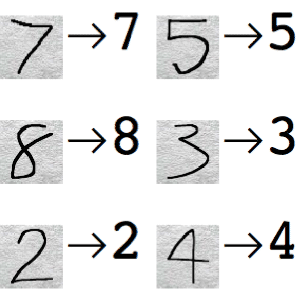

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


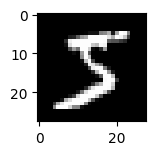

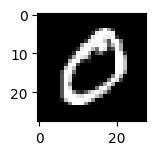

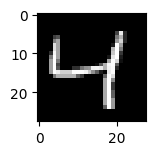

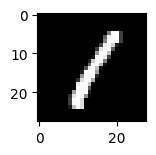

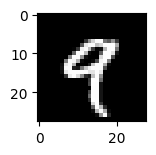

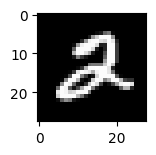

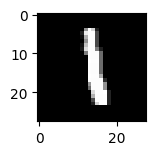

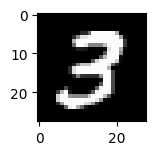

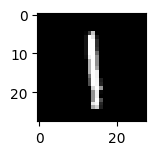

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  # print(trainX.shape,trainY.shape)
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0],28,28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



Tham khảo tác giả : https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [ ]:
def define_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same',
                     activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Strides mặc định là (2, 2)
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Strides mặc định là (2, 2)
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-5,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=15,
        restore_best_weights=True,
        verbose=1)
]

## Evaluate Model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0,callbacks=callbacks)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories,model

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories,model = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)
  model.save('/content/drive/MyDrive/bao/model_7.h5')

> 99.358
> 99.242
> 99.200
> 99.292
> 99.325


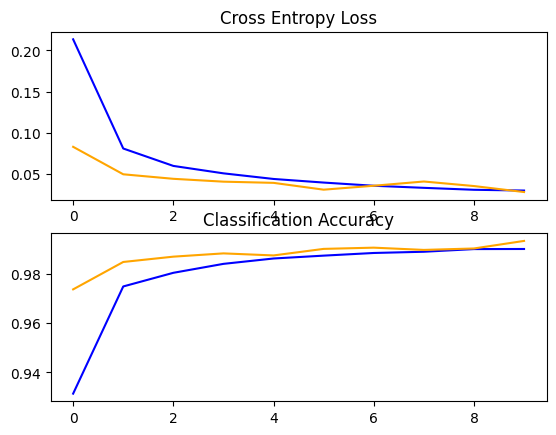

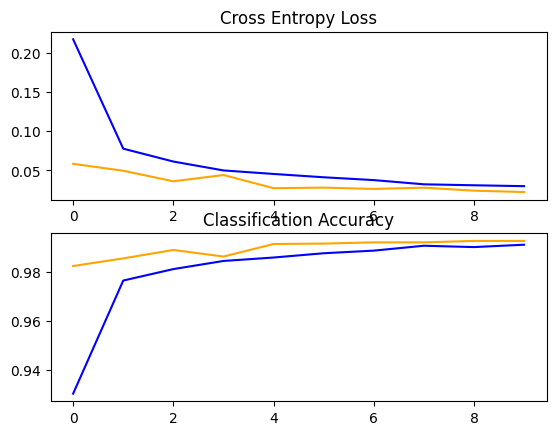

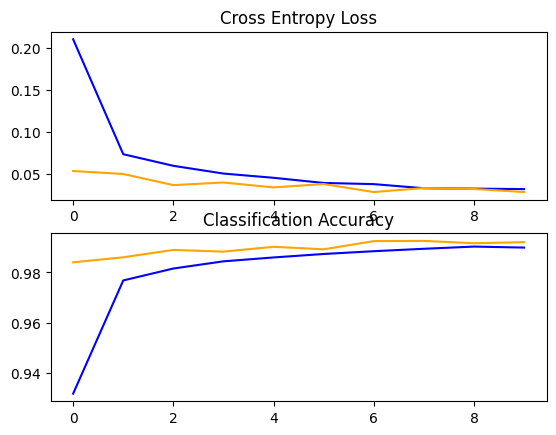

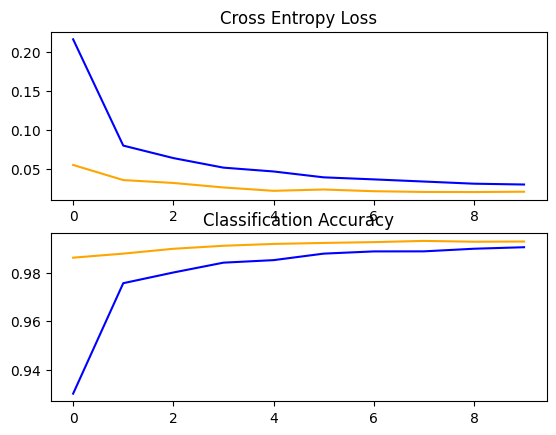

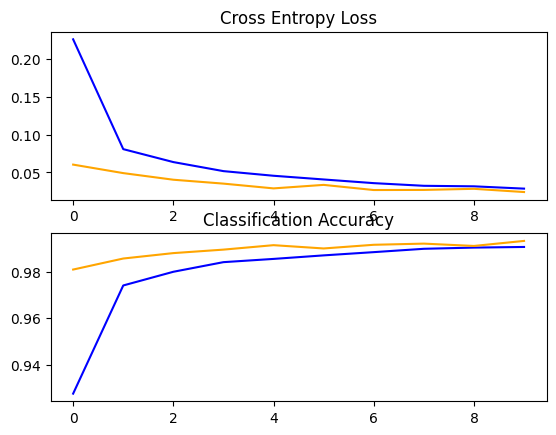

Accuracy: mean=99.283 std=0.057, n=5


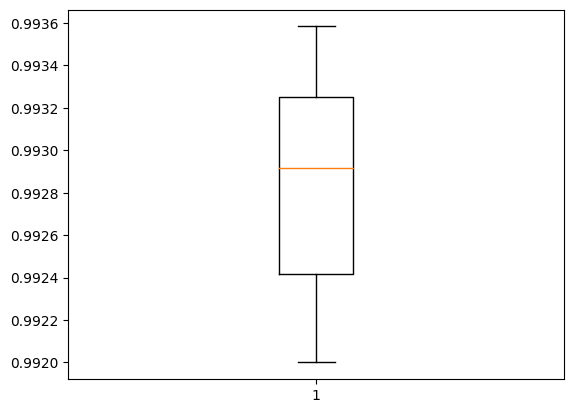

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('/content/drive/MyDrive/bao/final_model3.h5')

## Evaluate Final Model

In [ ]:
run_test_harness2()

(60000, 28, 28) (60000,)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [ ]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [ ]:
import cv2
import numpy as np

In [ ]:
def change(num):
  while num<0:
    num = num +10

  return num

In [ ]:
  min_y = min_y-50
  max_y = max_y+50
  min_x = min_x-50
  max_x = max_x+50

NameError: name 'min_y' is not defined

In [ ]:
# load an image and predict the class
#delta la do doi cho tung contour box
def run_example(path, visualize = False, delta = 40):
  # load the image
  image = cv2.imread(path)
  grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(grey.copy(), 155, 255, cv2.THRESH_BINARY_INV)
  contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  arr = []
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    arr.append((x,y))

  min_x = float('inf')
  min_y = float('inf')
  max_x = float('-inf')
  max_y = float('-inf')

  for x, y in arr:
      min_x = min(min_x, x)
      min_y = min(min_y, y)
      max_x = max(max_x, x + w)
      max_y = max(max_y, y + h)

  cv2.rectangle(image, (min_x,max_y ), (max_x, min_y), color=(0, 255, 0), thickness=2)

  img = cv2.imread(path)
  min_y = min_y-delta
  max_y = max_y+delta
  min_x = min_x-delta
  max_x = max_x+delta
  crop_img = img[min_y:max_y, min_x:max_x]
  grey = cv2.cvtColor(crop_img.copy(), cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(grey.copy(), 155, 255, cv2.THRESH_BINARY_INV)
  resized_digit =  cv2.resize(thresh.copy(), (28, 28) , interpolation=cv2.INTER_CUBIC)

  # predict the class
  image_file = np.array(resized_digit)
  prediction = model.predict(image_file.reshape(1, 28, 28, 1))

  digit = argmax(prediction)
  if visualize == True:
      plt.imshow(image)
      plt.show()
  return digit

In [ ]:
model = load_model('/content/drive/MyDrive/bao/final_model.h5')
for i in range(0, 10,1):
    dir1 = f'/content/drive/MyDrive/data/number/{i}1.jpg'
    dir2 = f'/content/drive/MyDrive/data/number/{i}2.jpg'
    dir3 = f'/content/drive/MyDrive/data/number/{i}3.jpg'

    digit1 = run_example(dir1)
    digit2 = run_example(dir2)
    digit3 = run_example(dir3)

    print(digit1, digit2, digit3)

1/1 [==============================] - 0s 29ms/step
5 3 5
1/1 [==============================] - 0s 25ms/step
4 4 4
1/1 [==============================] - 0s 26ms/step
2 2 2
1/1 [==============================] - 0s 29ms/step
3 3 3
1/1 [==============================] - 0s 27ms/step
4 7 8
1/1 [==============================] - 0s 29ms/step
5 5 5
1/1 [==============================] - 0s 30ms/step
7 6 5
1/1 [==============================] - 0s 37ms/step
7 4 2
1/1 [==============================] - 0s 20ms/step
8 9 8
1/1 [==============================] - 0s 17ms/step
7 9 9





----------------Contoured Image--------------------


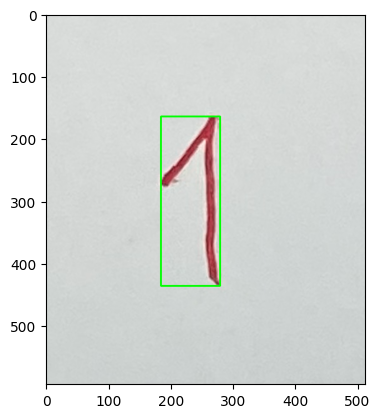

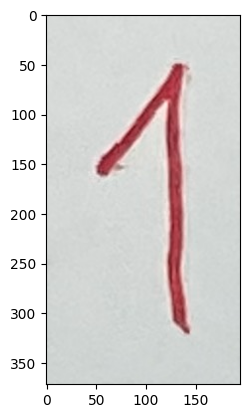

In [ ]:
#visualize cho tung func
path = '/content/drive/MyDrive/data/number/13.jpg'
image = cv2.imread(path)
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 155, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

arr = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    arr.append((x,y))

min_x = float('inf')
min_y = float('inf')
max_x = float('-inf')
max_y = float('-inf')

for x, y in arr:
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)
cv2.rectangle(image, (min_x,max_y ), (max_x, min_y), color=(0, 255, 0), thickness=2)

print("\n\n\n----------------Contoured Image--------------------")

plt.imshow(image, cmap="gray")
plt.show()

img = cv2.imread(path)
crop_img = img[min_y-50:max_y+50, min_x-50:max_x+50]
plt.imshow(crop_img)
plt.show()

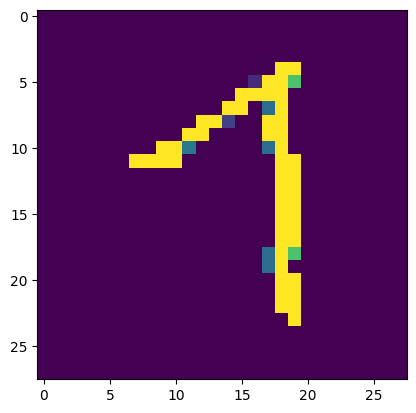

In [ ]:
grey = cv2.cvtColor(crop_img.copy(), cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(grey.copy(), 155, 255, cv2.THRESH_BINARY_INV)
resized_digit =  cv2.resize(thresh.copy(), (28, 28) , interpolation=cv2.INTER_CUBIC)
plt.imshow(resized_digit)
plt.show()

In [ ]:
model = load_model('final_model.h5')

image_file = np.array(resized_digit)
prediction = model.predict(image_file.reshape(1, 28, 28, 1))

digit = argmax(prediction)
print(digit)

1/1 [==============================] - 0s 60ms/step
7
